# Introduction
- random_forest_regressor でstackingを行う
- hyperopt でチューニングも行う

# Import everything I need :)

In [30]:
import warnings
warnings.filterwarnings('ignore')
import time
import multiprocessing
import glob
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, BaggingRegressor
from functools import partial
import lightgbm as lgb
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from fastprogress import progress_bar

# Preparation

In [142]:
nb = '99-01'
isSmallSet = False
length = 100000
model_name = 'lgb'

In [143]:
pd.set_option('display.max_columns', 200)

In [144]:
file_path = '../input/champs-scalar-coupling/'
glob.glob(file_path + '*')

['../input/champs-scalar-coupling/nb29_fc_train_feature.csv',
 '../input/champs-scalar-coupling/train_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/mulliken_charges.csv',
 '../input/champs-scalar-coupling/nb33_train_dist-interaction.csv',
 '../input/champs-scalar-coupling/test_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/structures.csv',
 '../input/champs-scalar-coupling/magnetic_shielding_tensors.csv',
 '../input/champs-scalar-coupling/train.csv',
 '../input/champs-scalar-coupling/nb47_fc_test.csv',
 '../input/champs-scalar-coupling/dipole_moments.csv',
 '../input/champs-scalar-coupling/test.csv',
 '../input/champs-scalar-coupling/nb29_fc_test_feature.csv',
 '../input/champs-scalar-coupling/scalar_coupling_contributions.csv',
 '../input/champs-scalar-coupling/nb47_fc_train.csv',
 '../input/champs-scalar-coupling/potential_energy.csv',
 '../input/champs-scalar-coupling/sample_submission.csv',

In [145]:
# train
path = file_path + 'train.csv'
if isSmallSet:
    train = pd.read_csv(path) [:length]
else:
    train = pd.read_csv(path)
    
type_train = train.type.values

In [146]:
# train
path = file_path + 'test.csv'
if isSmallSet:
    test = pd.read_csv(path) [:length]
else:
    test = pd.read_csv(path)
    
type_test = test.type.values

## myFunc
**metrics**

In [147]:
def kaggle_metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

In [148]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Stacking

In [149]:
path_list = [
'nb60_{}_lgb_-1.5330660525700779.csv',
'nb77_{}_lgb_-1.3808933285661147.csv',
'nb79_{}_extra_trees_regressor_-1.56760.csv',
'nb80_{}_extra_trees_regressor_-1.48000.csv',
'nb81_{}_bagging_regressor_-1.44452.csv',
'nb82_{}_bagging_regressor_-1.36181.csv',
'nb84_{}_extra_trees_regressor_-1.60943.csv',
'nb85_{}_extra_trees_regressor_-1.52972.csv',
'nb88_{}_lgb_-1.547953965914086.csv',
'nb91_{}_extra_trees_regressor_-1.47467.csv',
]

In [150]:
# oof
oofs = []
for path in path_list:
    if isSmallSet:
        df = pd.read_csv('./../output/' + path.format('oof'))[:length]
    else:
        df = pd.read_csv('./../output/' + path.format('oof'))
#         df = reduce_mem_usage(df)
    oofs.append(df)

In [151]:
# sub
subs = []
for path in path_list:
    if isSmallSet:
        df = pd.read_csv('./../output/' + path.format('submission')).drop(['id'], axis=1)[:length]
    else:
        df = pd.read_csv('./../output/' + path.format('submission')).drop(['id'], axis=1)
#         df = reduce_mem_usage(df)
    subs.append(df)

<br>
<br>
plot

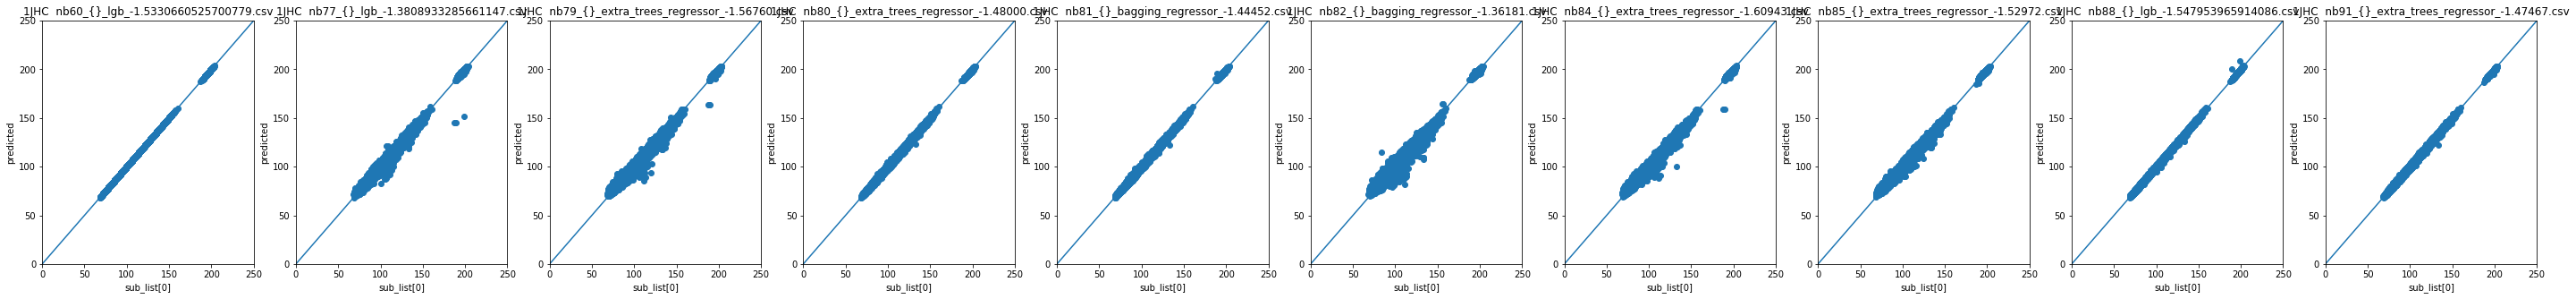

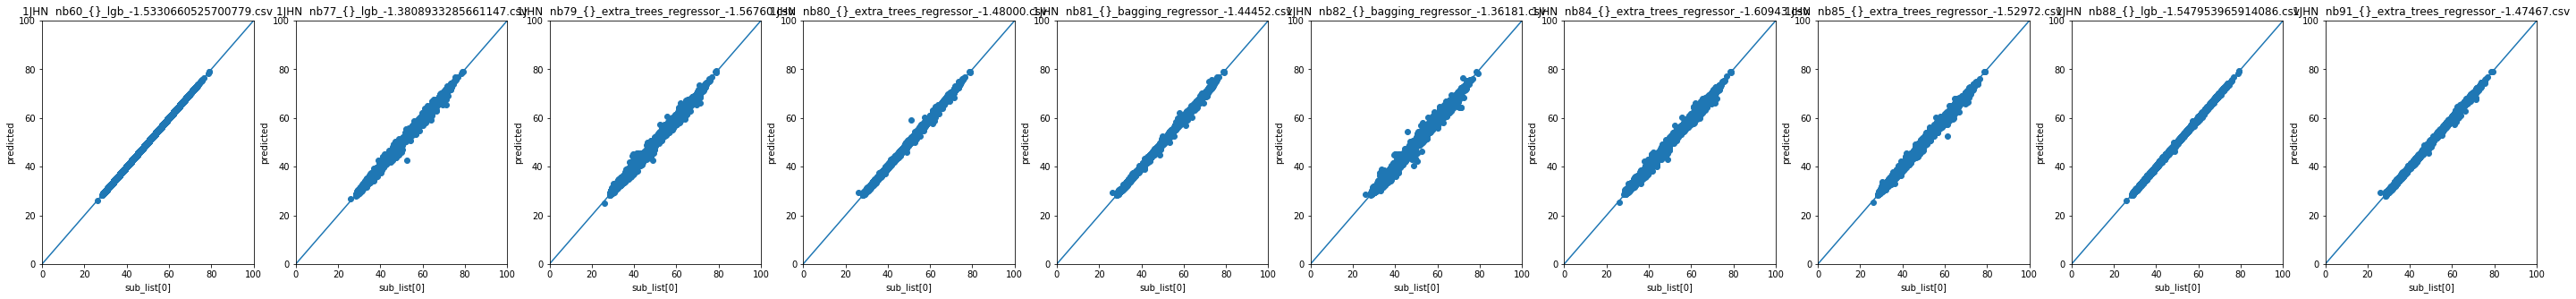

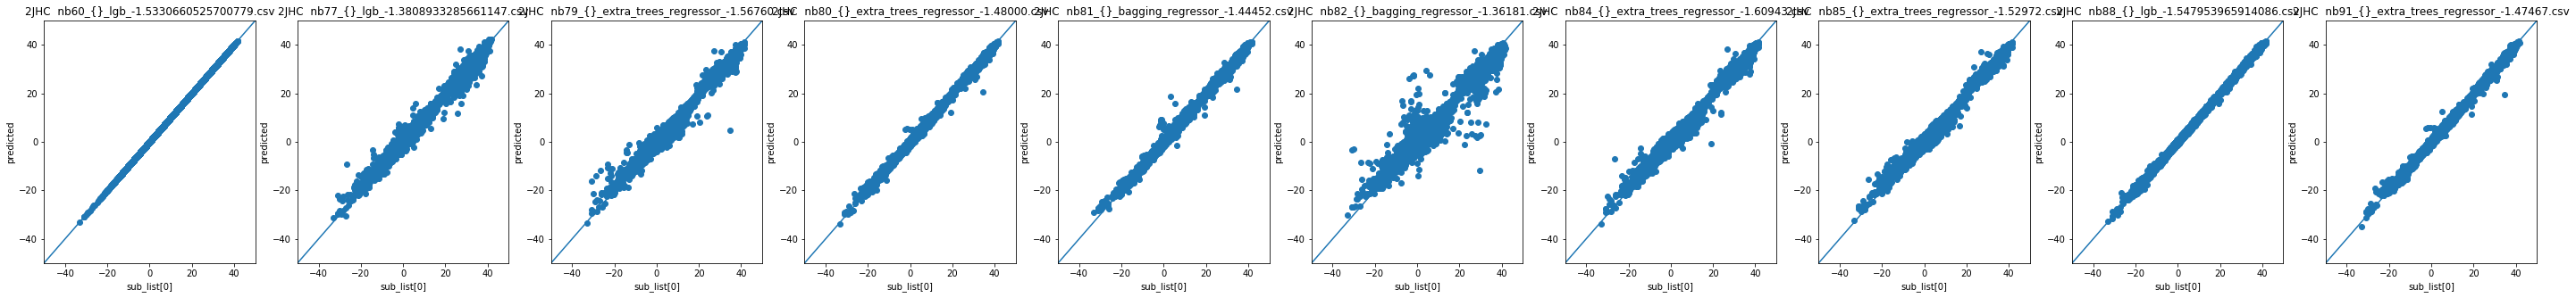

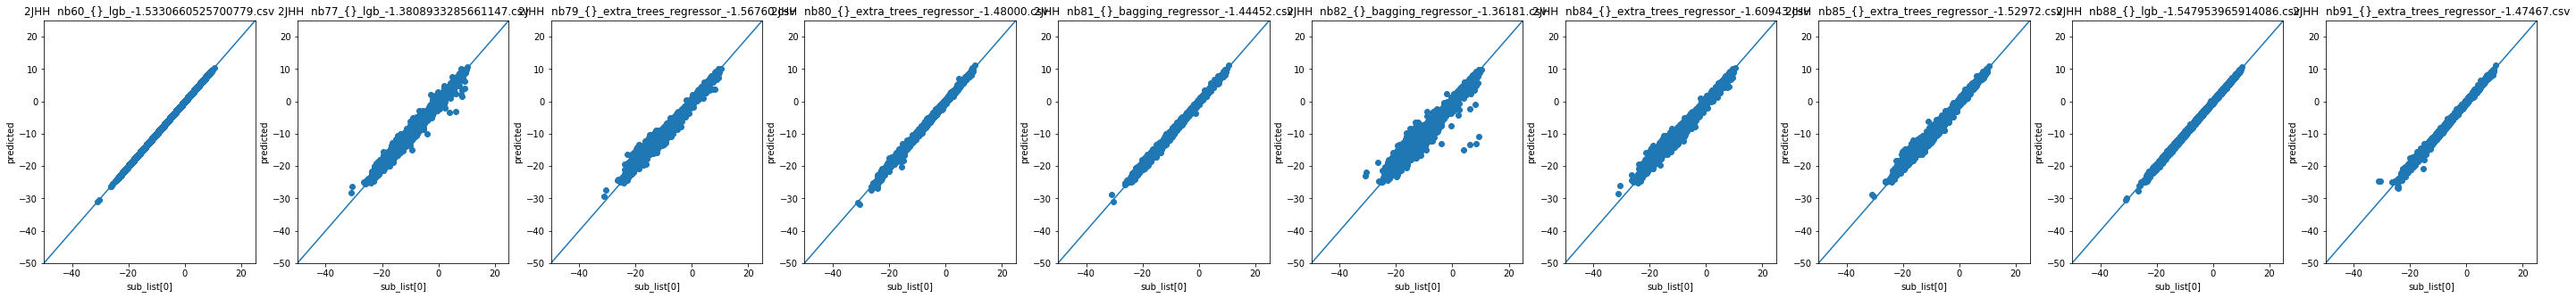

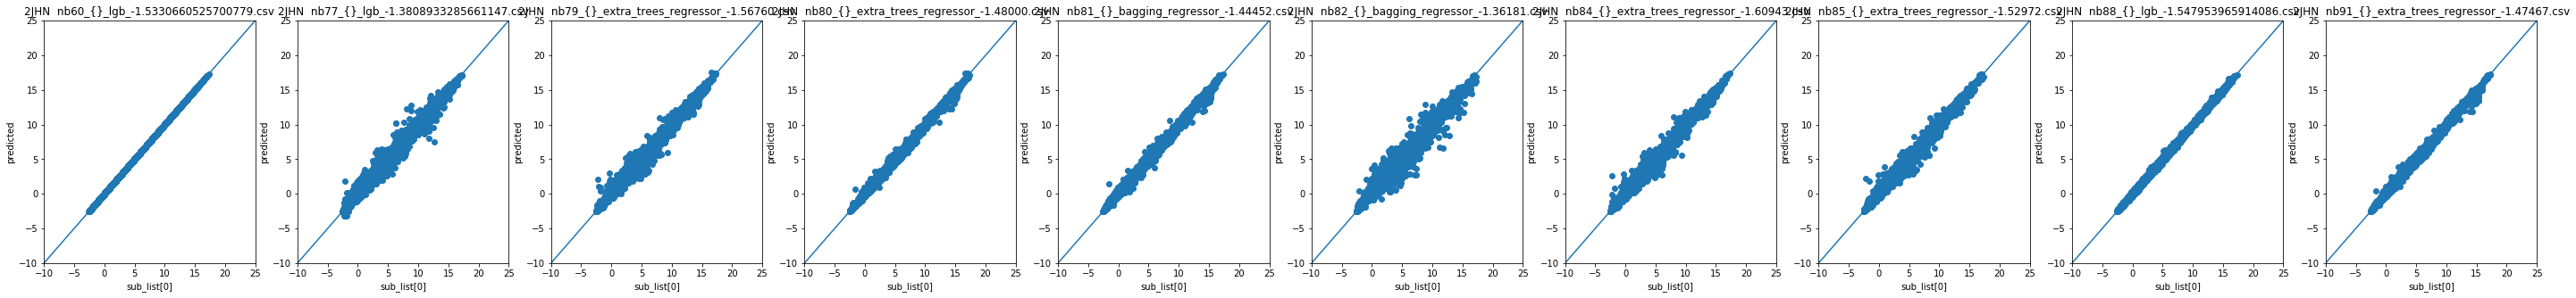

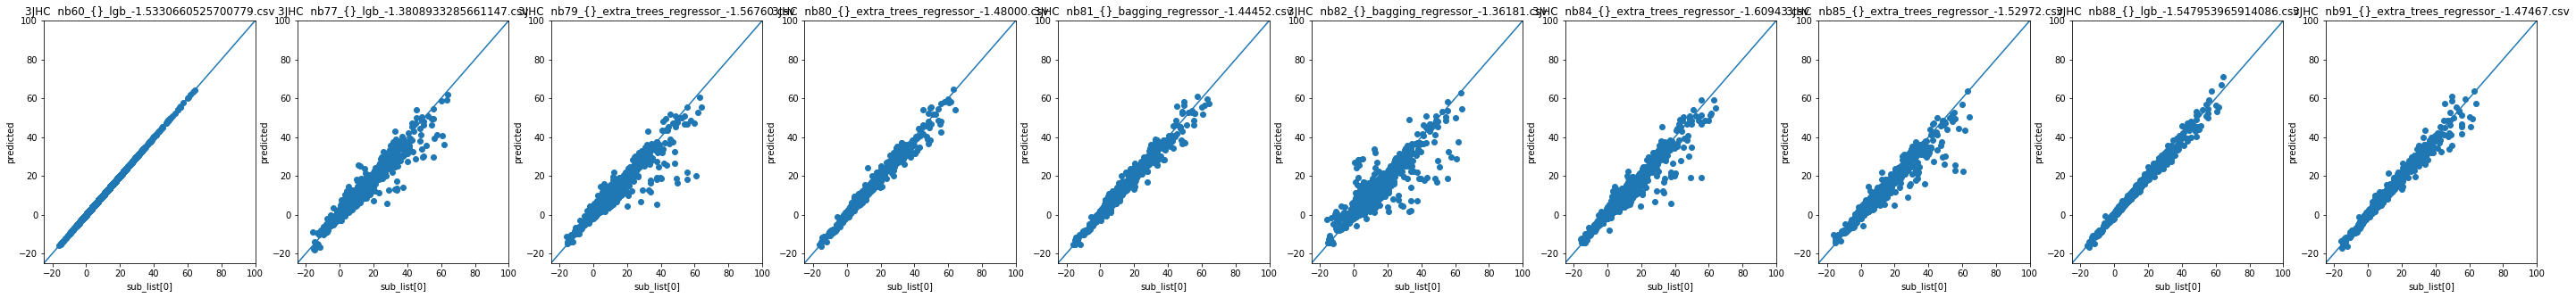

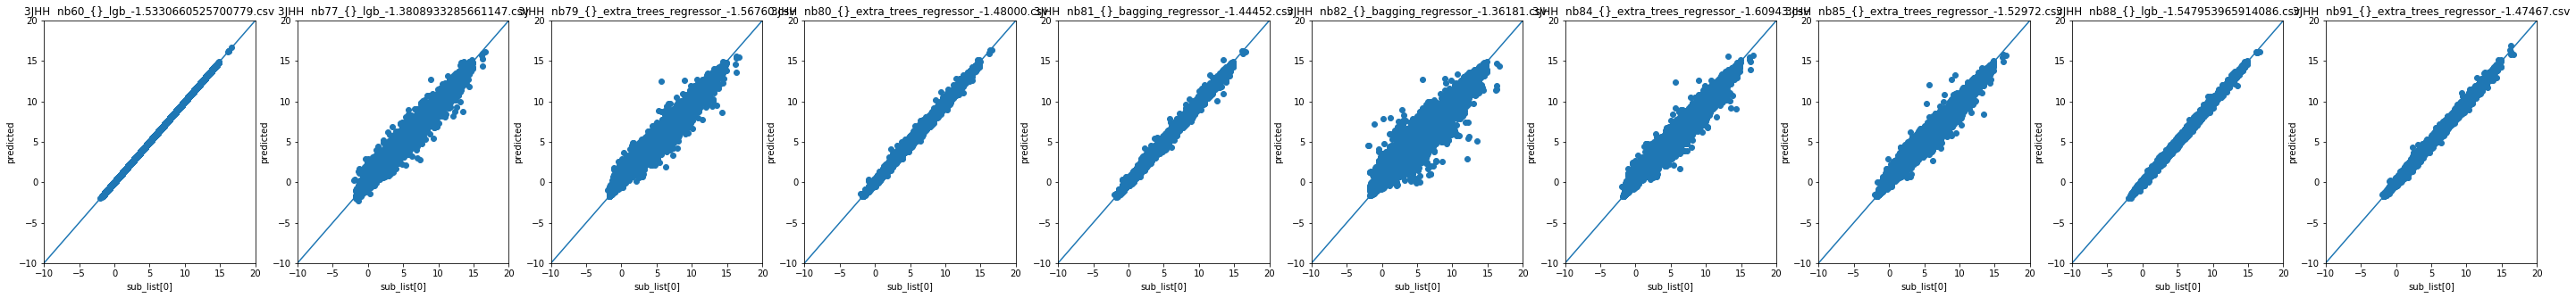

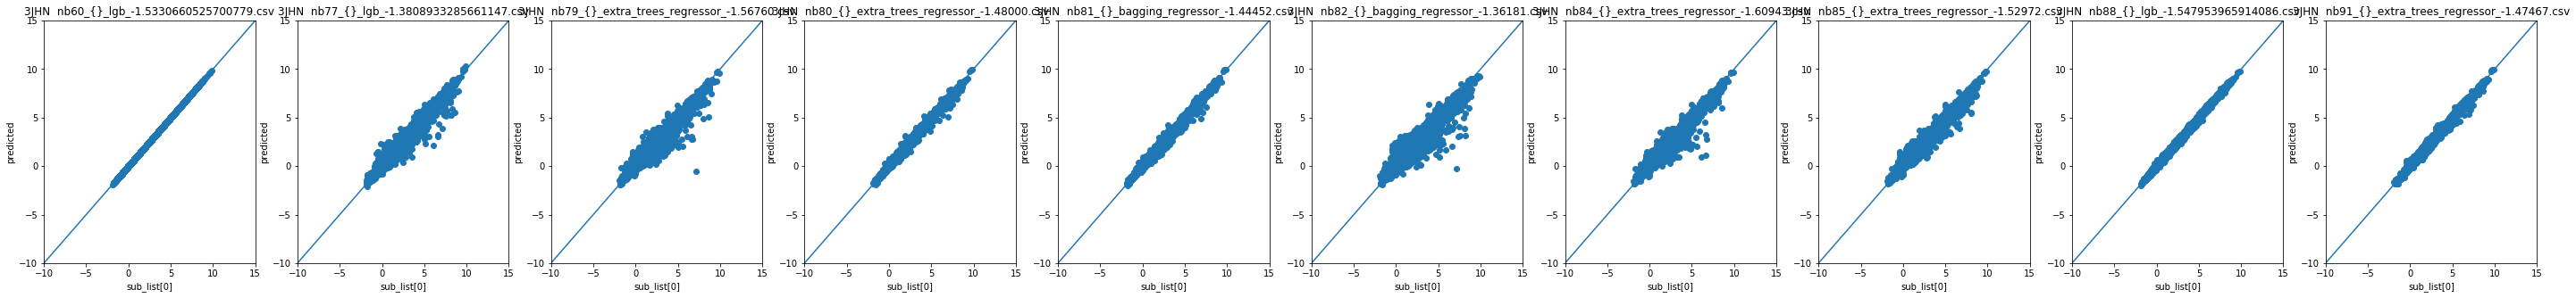

In [63]:
sub_list = [df.scalar_coupling_constant.values for df in subs ] 
model_names = path_list
# types = lbl.inverse_transform(X['type'])
types = type_test

def plot_oof_preds(ctype, llim, ulim):
    fig, axs = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))
    axs = axs.ravel()
    for i in range(len(model_names)):
        model_name = model_names[i]
        t_idx = types==ctype
#         y = train.scalar_coupling_constant.values
        axs[i].scatter(sub_list[0][t_idx], sub_list[i][t_idx])
        axs[i].set_xlim((llim, ulim))
        axs[i].set_ylim((llim, ulim))
        axs[i].plot([llim, ulim], [llim, ulim])
        axs[i].set_xlabel('sub_list[0]')
        axs[i].set_ylabel('predicted')
        axs[i].set_title(f'{ctype}  {model_names[i]}', fontsize=12)
        
plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 25)
plot_oof_preds('2JHN', -10, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -10, 20)
plot_oof_preds('3JHN', -10, 15)

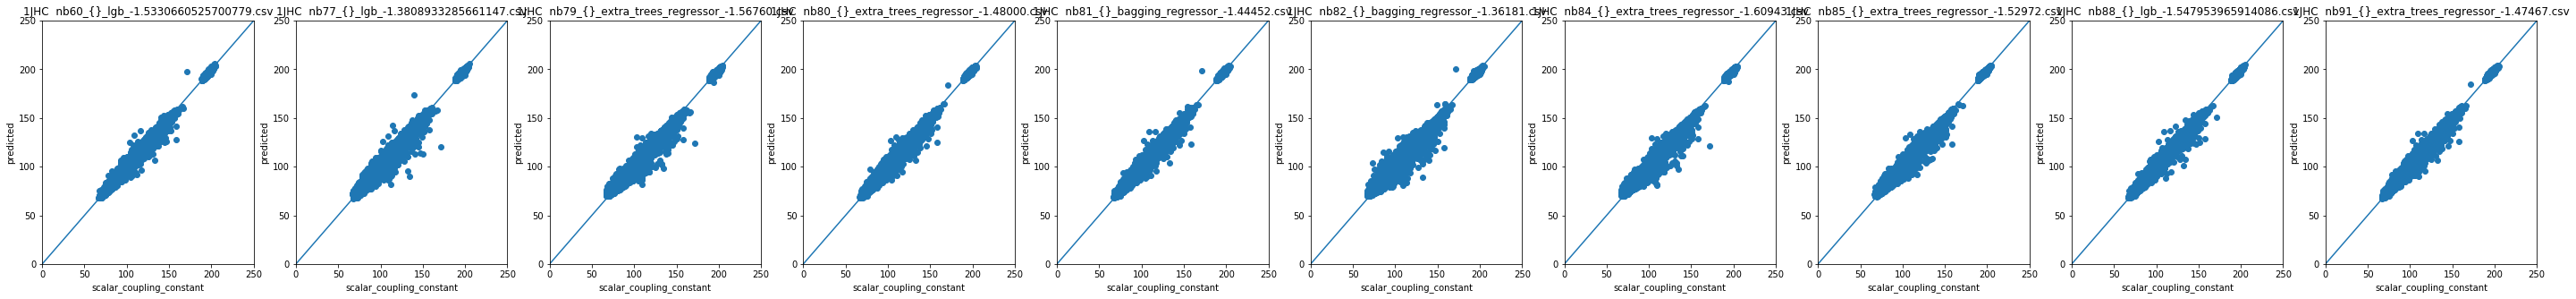

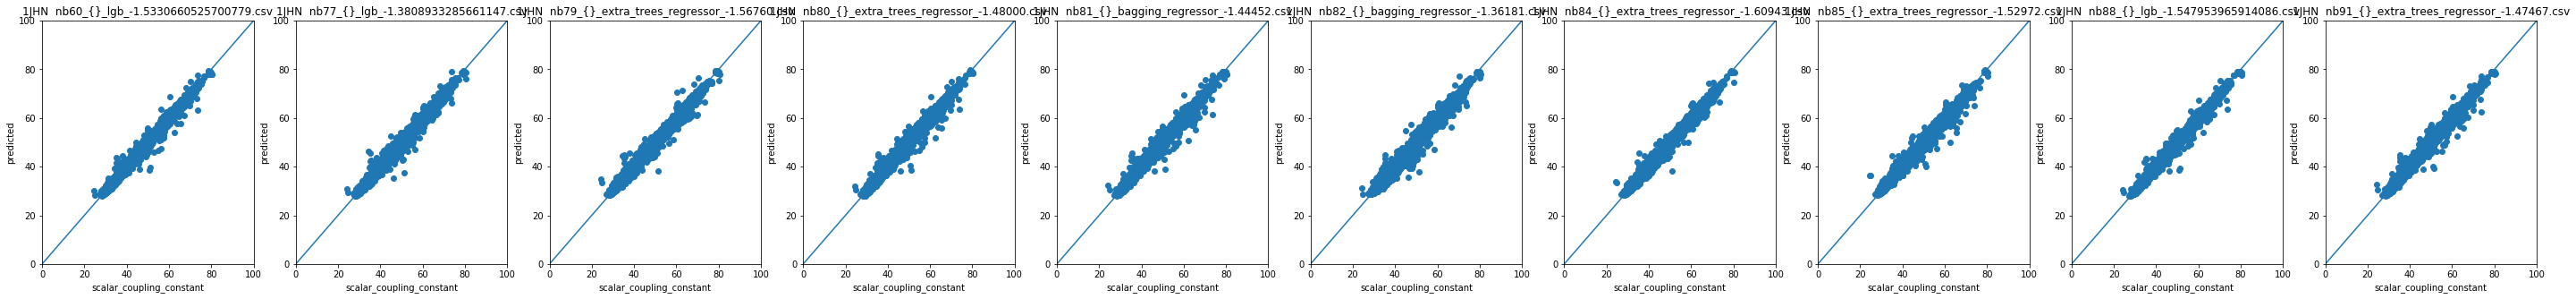

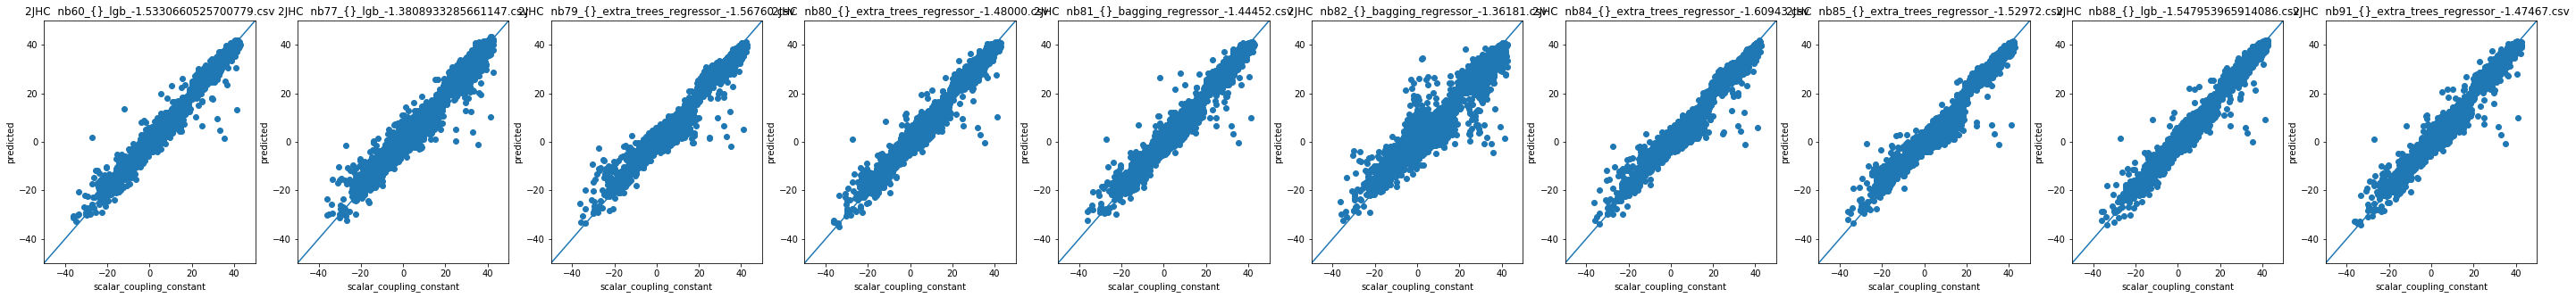

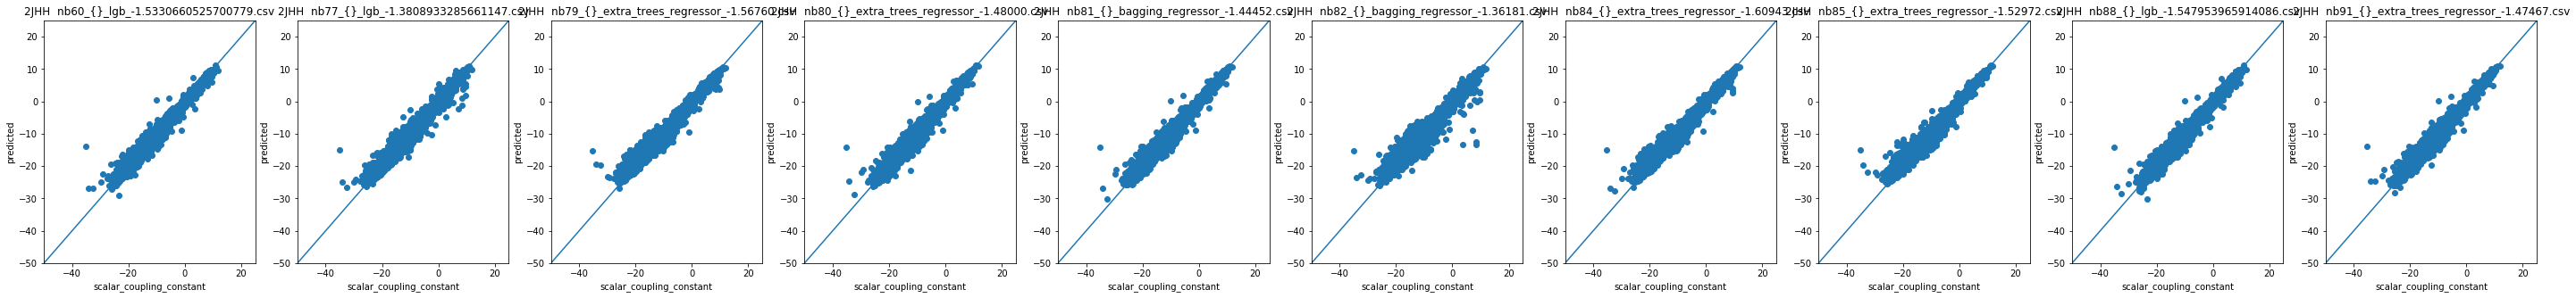

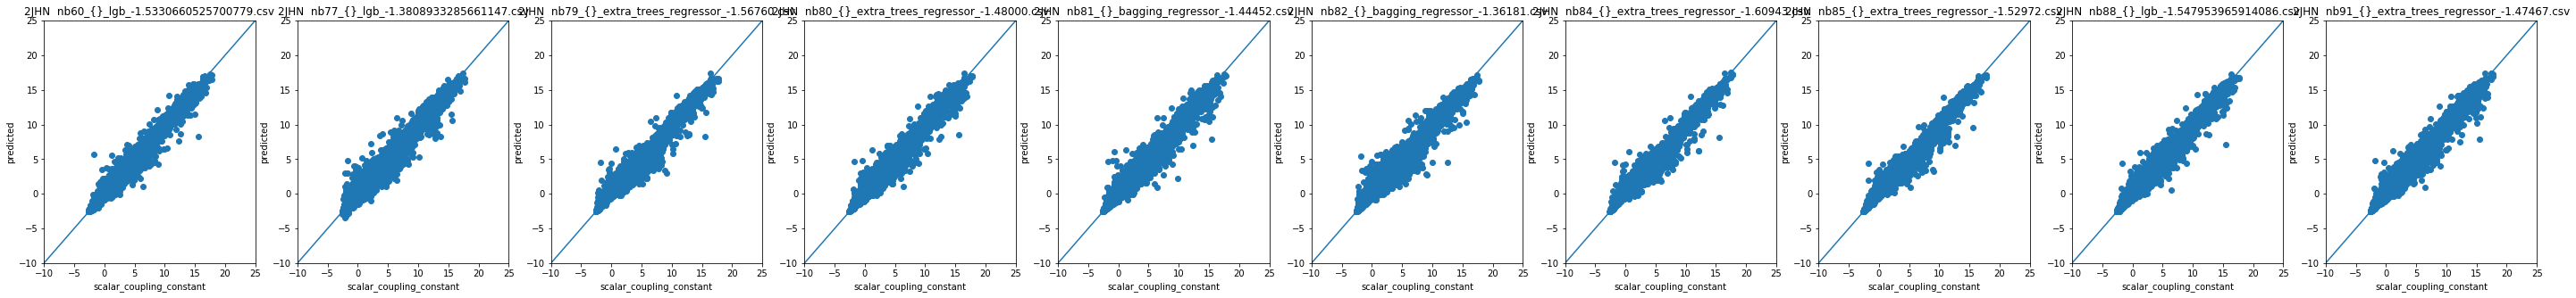

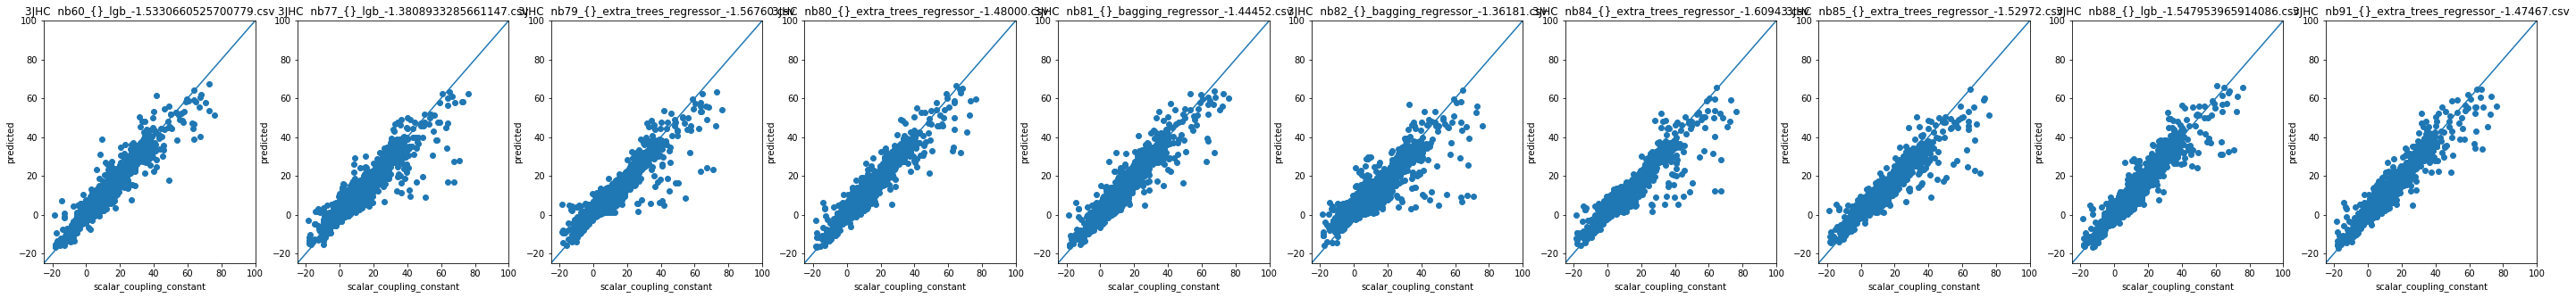

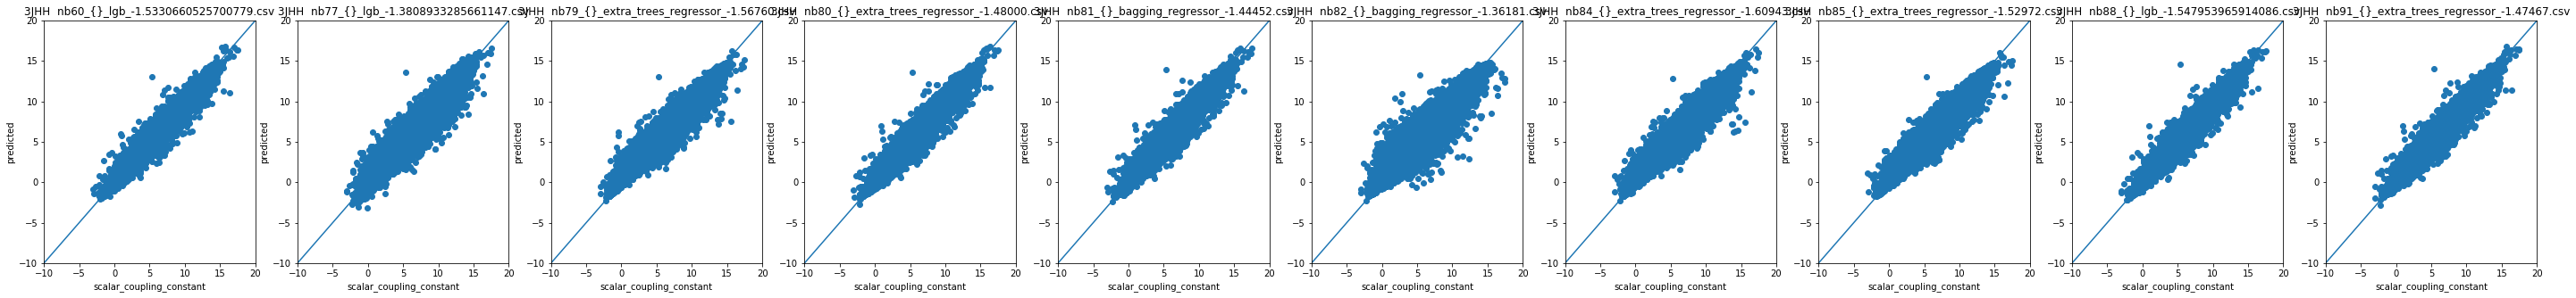

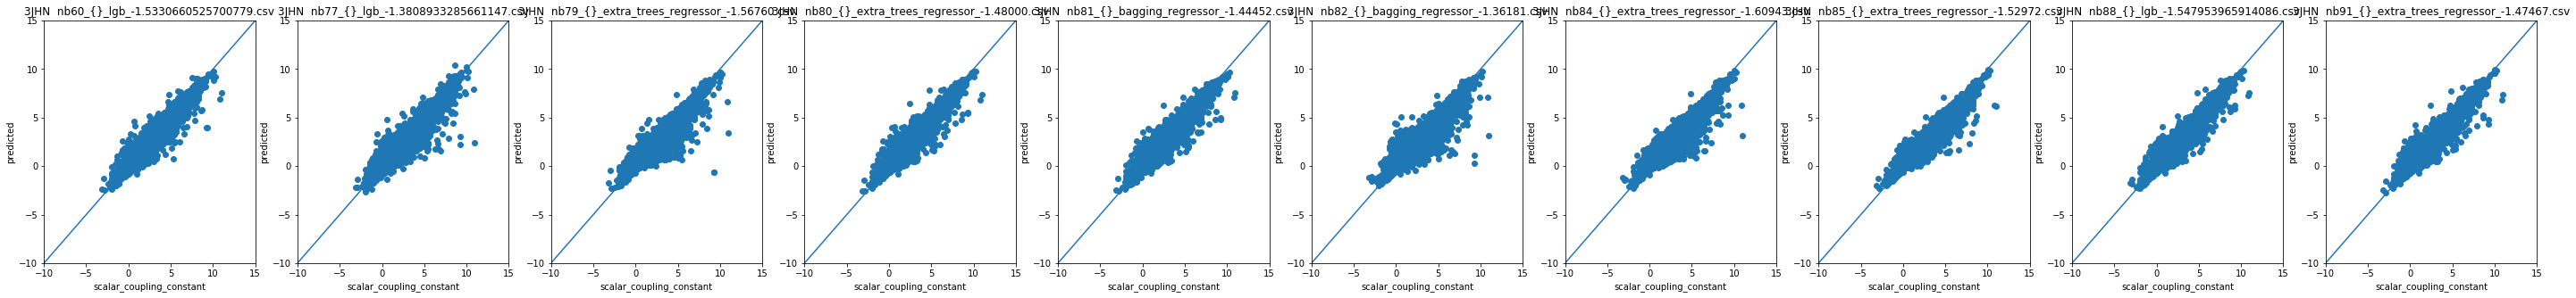

In [41]:
oof_list = [df.oof.values for df in oofs ] 
model_names = path_list
# types = lbl.inverse_transform(X['type'])
types = type_train

def plot_oof_preds(ctype, llim, ulim):
    fig, axs = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))
    axs = axs.ravel()
    for i in range(len(model_names)):
        model_name = model_names[i]
        t_idx = types==ctype
        y = train.scalar_coupling_constant.values
        axs[i].scatter(y[t_idx], oof_list[i][t_idx])
        axs[i].set_xlim((llim, ulim))
        axs[i].set_ylim((llim, ulim))
        axs[i].plot([llim, ulim], [llim, ulim])
        axs[i].set_xlabel('scalar_coupling_constant')
        axs[i].set_ylabel('predicted')
        axs[i].set_title(f'{ctype}  {model_names[i]}', fontsize=12)
        
plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 25)
plot_oof_preds('2JHN', -10, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -10, 20)
plot_oof_preds('3JHN', -10, 15)

# Create train, test data

LabelEncode
- `type`   = {2JHC, ...}

In [152]:
lbl = LabelEncoder()
lbl.fit(list(type_train) + list(type_test))
type_train_lbl = lbl.transform(type_train)
type_test_lbl = lbl.transform(type_test)

In [153]:
y = train.scalar_coupling_constant
X = pd.concat(oofs, axis=1)
X = pd.DataFrame(X.values, columns=path_list)
X_test = pd.concat(subs, axis=1)
X_test = pd.DataFrame(X_test.values, columns=path_list)
X['type'] = type_train_lbl
X_test['type'] = type_test_lbl

In [154]:
del train, test

In [155]:
gc.collect()

18960

# Hyperopt

In [156]:
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                  y,
                                                  test_size = 0.30, 
                                                  random_state = 0)

In [157]:
# Define searched space
hyper_space = {'objective': 'regression',
               'metric':'mae',
               'boosting':'gbdt',
               'max_depth':  hp.choice('max_depth', [5, 8, 10, 15]),
               'num_leaves': hp.choice('num_leaves', [50, 100, 250]),
               'subsample': hp.choice('subsample', [.3, .5, .7, 1]),
               'subsample_freq': 1,
               'colsample_bytree': hp.choice('colsample_bytree', [ .6, .8, 1]),
               'learning_rate': hp.choice('learning_rate', [0.01, .1, .3]),
               'reg_alpha': hp.choice('reg_alpha', [.1, .2, .4, .6]),
               'reg_lambda':  hp.choice('reg_lambda', [.1, .2, .4, .6]),               
               'min_child_samples': hp.choice('min_child_samples', [20, 45, 70, 100]),
               'verbosity': -1,
               'bagging_seed': 11,
              }

MAX_EVALS= 20

In [169]:
%%time
# type ごとの学習 

best_params_list = []
# for t in sorted(X_train['type'].unique()):
for t in sorted(np.unique(type_train_lbl)):
    print('*'*80)
    print(f'- Training of type {t}')
    print('*'*80)
    X_t_train = X_train.loc[X_train['type'] == t]
    X_t_valid = X_valid.loc[X_valid['type'] == t]
    y_t_train = y_train[X_train['type'] == t]
    y_t_valid = y_valid[X_valid['type'] == t]
    
    
    # evaluate_metric
    def evaluate_metric(params):
        model = lgb.LGBMRegressor(**params, n_estimators=450, random_state=42, n_jobs=75)  # <===============
        model.fit(X_t_train, y_t_train)

        pred = model.predict(X_t_valid)
        y_t_train_pred = model.predict(X_t_train)

        _X_t_valid = X_t_valid.copy()
        _X_t_valid['scalar_coupling_constant'] = y_t_valid
        cv_score = kaggle_metric(_X_t_valid, pred)
        _X_t_valid = _X_t_valid.drop(['scalar_coupling_constant'], axis=1)

#         print(f'mae(valid): {mean_absolute_error(y_t_valid, pred)}')
        
        print(params)
        print(f'training l1: {mean_absolute_error(y_t_train, y_t_train_pred) :.5f}	\t valid l1: {mean_absolute_error(y_t_valid, pred) :.5f} ')
        print(f'cv_score: {cv_score}')
        print('-'*80)
        print('\n')

        return {
            'loss': cv_score,
            'status': STATUS_OK,
            'stats_running': STATUS_RUNNING
        }
    
    
    # hyperopt
    # Trail
    trials = Trials()

    # Set algoritm parameters
    algo = partial(tpe.suggest, 
                   n_startup_jobs=1)


    # Fit Tree Parzen Estimator
    best_vals = fmin(evaluate_metric, space=hyper_space, verbose=1,
                     algo=algo, max_evals=MAX_EVALS, trials=trials)

    # Print best parameters
    best_params = space_eval(hyper_space, best_vals)
    best_params_list.append(best_params)
    print("BEST PARAMETERS: " + str(best_params))
    print('')

********************************************************************************
- Training of type 0
********************************************************************************
{'bagging_seed': 11, 'boosting': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 8, 'metric': 'mae', 'min_child_samples': 20, 'num_leaves': 50, 'objective': 'regression', 'reg_alpha': 0.4, 'reg_lambda': 0.1, 'subsample': 0.5, 'subsample_freq': 1, 'verbosity': -1}
training l1: 0.57184		 valid l1: 0.59367            
cv_score: -0.5214326256057773                       
--------------------------------------------------------------------------------
{'bagging_seed': 11, 'boosting': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 8, 'metric': 'mae', 'min_child_samples': 20, 'num_leaves': 50, 'objective': 'regression', 'reg_alpha': 0.4, 'reg_lambda': 0.1, 'subsample': 0.5, 'subsample_freq': 1, 'verbosity': -1}
training l1: 0.57184		 valid l1: 0.59367                      

In [170]:
best_params_list

[{'bagging_seed': 11,
  'boosting': 'gbdt',
  'colsample_bytree': 1,
  'learning_rate': 0.1,
  'max_depth': 15,
  'metric': 'mae',
  'min_child_samples': 45,
  'num_leaves': 100,
  'objective': 'regression',
  'reg_alpha': 0.1,
  'reg_lambda': 0.6,
  'subsample': 1,
  'subsample_freq': 1,
  'verbosity': -1},
 {'bagging_seed': 11,
  'boosting': 'gbdt',
  'colsample_bytree': 0.8,
  'learning_rate': 0.1,
  'max_depth': 10,
  'metric': 'mae',
  'min_child_samples': 70,
  'num_leaves': 50,
  'objective': 'regression',
  'reg_alpha': 0.1,
  'reg_lambda': 0.2,
  'subsample': 0.7,
  'subsample_freq': 1,
  'verbosity': -1},
 {'bagging_seed': 11,
  'boosting': 'gbdt',
  'colsample_bytree': 0.8,
  'learning_rate': 0.1,
  'max_depth': 10,
  'metric': 'mae',
  'min_child_samples': 20,
  'num_leaves': 250,
  'objective': 'regression',
  'reg_alpha': 0.2,
  'reg_lambda': 0.1,
  'subsample': 0.7,
  'subsample_freq': 1,
  'verbosity': -1},
 {'bagging_seed': 11,
  'boosting': 'gbdt',
  'colsample_bytree

# Training model

**params**

In [171]:
# Configuration
RANDOM_STATE = 0

model_params_list = best_params_list

In [172]:
n_folds = 6
folds = KFold(n_splits=n_folds, shuffle=True)

In [173]:
def train_model(X, X_test, y, folds, model_params):
#     model = lgb.LGBMRegressor(**lgb_params, n_estimators=n_estimators, n_jobs=N_JOBS, random_state=random_state)

    scores = []
    oof = np.zeros(len(X))  
    prediction = np.zeros(len(X))  
    result_dict = {}
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        

        # Train the model
        model = lgb.LGBMRegressor(**model_params, n_estimators=1500, random_state=42, n_jobs=75)  # <===============
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  verbose=300,
                  early_stopping_rounds=200)
        
        y_valid_pred = model.predict(X.iloc[valid_idx, :])
        y_train_pred = model.predict(X.iloc[train_idx, :])
        prediction = model.predict(X_test)
        oof[valid_idx] = y_valid_pred
        score = mean_absolute_error(y[valid_idx], y_valid_pred)
        score_train = mean_absolute_error(y[train_idx], y_train_pred)
        scores.append(score)

        print(f'fold {fold_n+1} train:{score_train :.5f} \t valid: {score :.5f}')
        print('')
    print('CV mean score    : {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    print('kaggle mean score: {0:.4f}'.format(np.log(np.mean(scores)))) 
    print('')
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    return result_dict

In [174]:
%%time
# type ごとの学習 

X_short = pd.DataFrame({'ind': list(X.index), 'type': type_train, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': type_test, 'prediction': [0] * len(X_test)})
for i, t in enumerate(np.unique(type_train)):
    idx = lbl.transform([t])[0]
    model_params = model_params_list[idx]
    print('*'*80)
    print(f'Training of type {t}, {idx}')
    print('*'*80)
    print(model_params)
    X_t = X.loc[type_train == t]
    X_test_t = X_test.loc[type_test == t]
    y_t = X_short.loc[type_train == t, 'target'].values
    
    result_dict = train_model(X_t, X_test_t, y_t, folds, model_params)
    X_short.loc[type_train == t, 'oof'] = result_dict['oof']
    X_short_test.loc[type_test == t, 'prediction'] = result_dict['prediction']
    
    

print('')
print('===== finish =====')
X['scalar_coupling_constant'] = y
metric = kaggle_metric(X, X_short['oof'])
X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)
print('CV mean score(group log mae): {0:.4f}'.format(metric))
prediction = X_short_test['prediction']

********************************************************************************
Training of type 1JHC, 0
********************************************************************************
{'bagging_seed': 11, 'boosting': 'gbdt', 'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 15, 'metric': 'mae', 'min_child_samples': 45, 'num_leaves': 100, 'objective': 'regression', 'reg_alpha': 0.1, 'reg_lambda': 0.6, 'subsample': 1, 'subsample_freq': 1, 'verbosity': -1}
Fold 1 started at Wed Aug 28 12:12:42 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's l1: 0.564757	valid_1's l1: 0.579196
Early stopping, best iteration is:
[369]	training's l1: 0.562278	valid_1's l1: 0.578924
fold 1 train:0.56228 	 valid: 0.57892

Fold 2 started at Wed Aug 28 12:12:53 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's l1: 0.568994	valid_1's l1: 0.581979
[600]	training's l1: 0.557046	valid_1's l1: 0.581913
Early stopping, best iteration is

# Save

**submission**

In [175]:
# path_submittion = './output/' + 'nb{}_submission_lgb_{}.csv'.format(nb, metric)
path_submittion = f'../output/nb{nb}_stack_submission_{model_name}_{metric :.5f}.csv'
print(f'save pash: {path_submittion}')

save pash: ../output/nb99-01_stack_submission_lgb_-1.75427.csv


In [197]:
submittion = pd.read_csv('../input/champs-scalar-coupling/sample_submission.csv')
# submittion = pd.read_csv('./input/champs-scalar-coupling/sample_submission.csv')[::100]
submittion['scalar_coupling_constant'] = prediction
if isSmallSet:
    pass
else:
    submittion.to_csv(path_submittion, index=False)

---
**result**

In [198]:
path_oof = f'../output/nb{nb}_stack_oof_{model_name}_{metric :.5f}.csv'
print(f'save pash: {path_oof}')

save pash: ../output/nb99-01_stack_oof_lgb_-1.75427.csv


In [199]:
oof = pd.DataFrame(X_short['oof'])
if isSmallSet:
    pass
else:
    oof.to_csv(path_oof, index=False)

# analysis

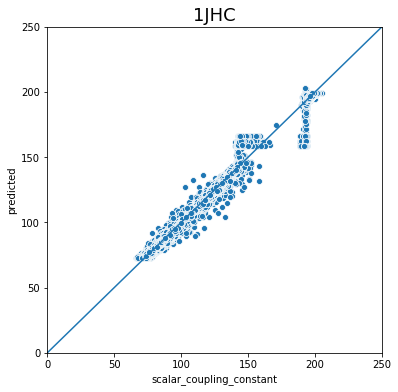

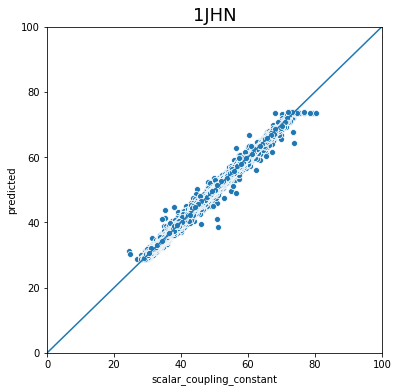

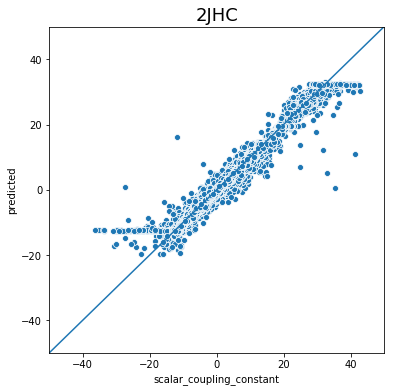

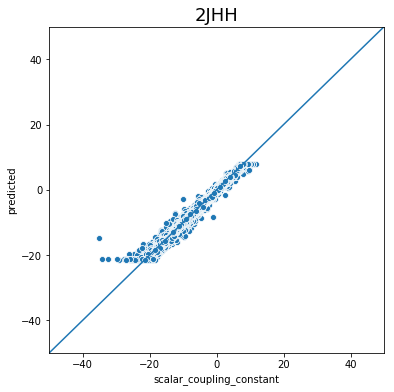

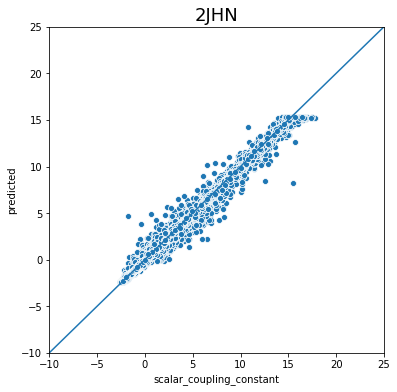

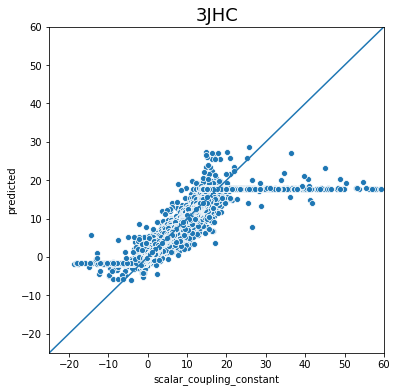

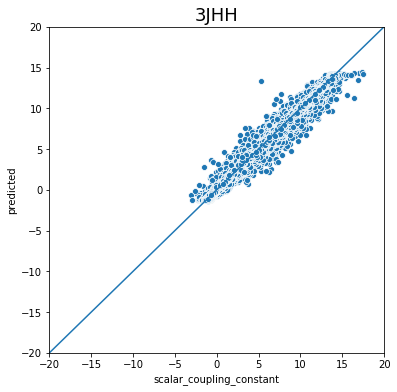

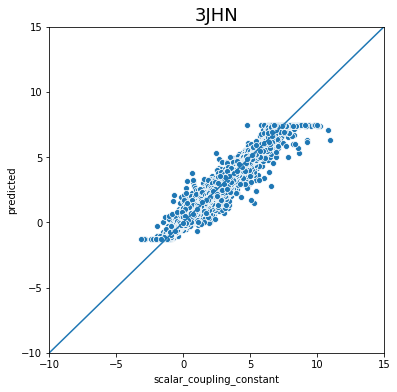

In [179]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = X_short['oof'].values
plot_data['type'] = type_train

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -10, 25)
plot_oof_preds('3JHC', -25, 60)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -10, 15)

In [135]:
len(X)

100000